In [1]:
import gymnasium as gym
import sys
import torch
import argparse
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math

from ppo import PPO

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Line Arguments 

In [2]:
"""
	This file contains the arguments to parse at command line.
	File main.py will call get_args, which then the arguments
	will be returned.
"""
def get_args():
	"""
		Description:
		Parses arguments at command line.

		Parameters:
			None

		Return:
			args - the arguments parsed
	"""
	parser = argparse.ArgumentParser()

	parser.add_argument('--mode', dest='mode', type=str, default='train')              # can be 'train' or 'test'
	parser.add_argument('--target_angle', dest='target_angle', type=str, default='0')   # your critic model filename
	parser.add_argument('--actor_model', dest='actor_model', type=str, default='')     # your actor model filename
	parser.add_argument('--critic_model', dest='critic_model', type=str, default='')   # your critic model filename
	

	args = parser.parse_args()

	return args

## Network

In [3]:
"""
	This file contains a neural network module for us to
	define our actor and critic networks in PPO.
"""
class FeedForwardNN(nn.Module):
	"""
		A standard in_dim-64-64-out_dim Feed Forward Neural Network.
	"""
	def __init__(self, in_dim, out_dim):
		"""
			Initialize the network and set up the layers.

			Parameters:
				in_dim - input dimensions as an int
				out_dim - output dimensions as an int

			Return:
				None
		"""
		super(FeedForwardNN, self).__init__()

		self.layer1 = nn.Linear(in_dim, 64)
		self.layer2 = nn.Linear(64, 64)
		self.layer3 = nn.Linear(64, out_dim)

	def forward(self, obs):
		"""
			Runs a forward pass on the neural network.

			Parameters:
				obs - observation to pass as input

			Return:
				output - the output of our forward pass
		"""
		# Convert observation to tensor if it's a numpy array
		if isinstance(obs, np.ndarray):
			obs = torch.tensor(obs, dtype=torch.float, device=device)

		activation1 = F.relu(self.layer1(obs))
		activation2 = F.relu(self.layer2(activation1))
		output = self.layer3(activation2)

		return output

## Evaluation Policy

In [4]:
"""
	This file is used only to evaluate our trained policy/actor after
	training in main.py with ppo.py. I wrote this file to demonstrate
	that our trained policy exists independently of our learning algorithm,
	which resides in ppo.py. Thus, we can test our trained policy without 
	relying on ppo.py.
"""
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()

ep_lens = []
ep_rets = []

def calculate_reward(observ, torque, target_angle): # Todos los valores estan en radianes
		theta = math.atan2(observ[1],observ[0])
		theta_dot = observ[2]
		
		theta_n = ((theta + np.pi) % (2*np.pi)) - np.pi

		theta_error = np.abs(theta_n - target_angle)
		
		#torque_castigo = (torque**2) - np.minimum(2-np.absolute(torque),0)
		torque_castigo = 0.001 * (torque**2)
		costs = (theta_error**2) + 0.1 * (theta_dot**2) + torque_castigo
		if theta_error <= 0.087: # ~ 5°
			reward_n = -costs + math.exp(-(8*theta_error)**2)
		else:
			reward_n = -costs
		# reward_n = -costs
		return reward_n

def _log_summary(ep_len, ep_ret, ep_num):
		"""
			Print to stdout what we've logged so far in the most recent episode.

			Parameters:
				None

			Return:
				None
		"""
		# # Round decimal places for more aesthetic logging messages
		# ep_len = str(round(ep_len, 2))
		# ep_ret = str(round(ep_ret, 2))

		# # Print logging statements
		# print(flush=True)
		# print(f"-------------------- Episode #{ep_num} --------------------", flush=True)
		# print(f"Episodic Length: {ep_len}", flush=True)
		# print(f"Episodic Return: {ep_ret}", flush=True)
		# print(f"------------------------------------------------------", flush=True)
		# print(flush=True)
  
		
		plt.figure(1)
		# Round decimal places for more aesthetic logging messages
		ep_len = round(ep_len, 2)
		ep_ret = round(ep_ret, 2)

		# Append to lists
		if ep_lens:
			ep_lens.append(ep_lens[-1] + ep_len)
		else:
			ep_lens.append(ep_len)
		ep_rets.append(ep_ret)

		# Clear previous plot
		plt.clf()

		# Plot
		plt.plot(ep_lens, ep_rets, color='blue')
		plt.title(f'Episode #{ep_num} - Episodic Length vs Episodic Return')
		plt.xlabel('Episodic Length')
		plt.ylabel('Episodic Return')
		plt.grid(True)
		plt.pause(0.01)
		if is_ipython:
			display.display(plt.gcf())
			display.clear_output(wait=True)

def rollout(policy, env, render, target_angle):
	"""
		Returns a generator to roll out each episode given a trained policy and
		environment to test on. 

		Parameters:
			policy - The trained policy to test
			env - The environment to evaluate the policy on
			render - Specifies whether to render or not
		
		Return:
			A generator object rollout, or iterable, which will return the latest
			episodic length and return on each iteration of the generator.

		Note:
			If you're unfamiliar with Python generators, check this out:
				https://wiki.python.org/moin/Generators
			If you're unfamiliar with Python "yield", check this out:
				https://stackoverflow.com/questions/231767/what-does-the-yield-keyword-do
	"""
	# Rollout until user kills process
	while True:
		# obs = env.reset()				# For Gym version
		obs, _ = env.reset()			# for Gymnasium version
		done = False

		# number of timesteps so far
		t = 0

		# Logging data
		ep_len = 0            # episodic length
		ep_ret = 0            # episodic return

		while not done:
			t += 1

			# Render environment if specified, off by default
			if render:
				env.render()

			# Query deterministic action from policy and run it
			action = policy(obs).detach().cpu().numpy()
			#obs, rew, done, _ = env.step(action)					# For Gym version
			obs, rew, terminated, truncated, _ = env.step(action)	# For Gymnasium version

			done = terminated or truncated							# For Gymnasium

			rew = calculate_reward(obs, action, math.radians(target_angle))

			# Sum all episodic rewards as we go along
			ep_ret += rew
			
		# Track episodic length
		ep_len = t

		# returns episodic length and return in this iteration
		yield ep_len, ep_ret

def eval_policy(policy, env, render=False, target_angle='0'):
	"""
		The main function to evaluate our policy with. It will iterate a generator object
		"rollout", which will simulate each episode and return the most recent episode's
		length and return. We can then log it right after. And yes, eval_policy will run
		forever until you kill the process. 

		Parameters:
			policy - The trained policy to test, basically another name for our actor model
			env - The environment to test the policy on
			render - Whether we should render our episodes. False by default.

		Return:
			None

		NOTE: To learn more about generators, look at rollout's function description
	"""
	# Rollout with the policy and environment, and log each episode's data
	for ep_num, (ep_len, ep_ret) in enumerate(rollout(policy, env, render, target_angle)):
		_log_summary(ep_len=ep_len, ep_ret=ep_ret, ep_num=ep_num)

## MAIN code

 >> Iteration #22


<Figure size 640x480 with 0 Axes>

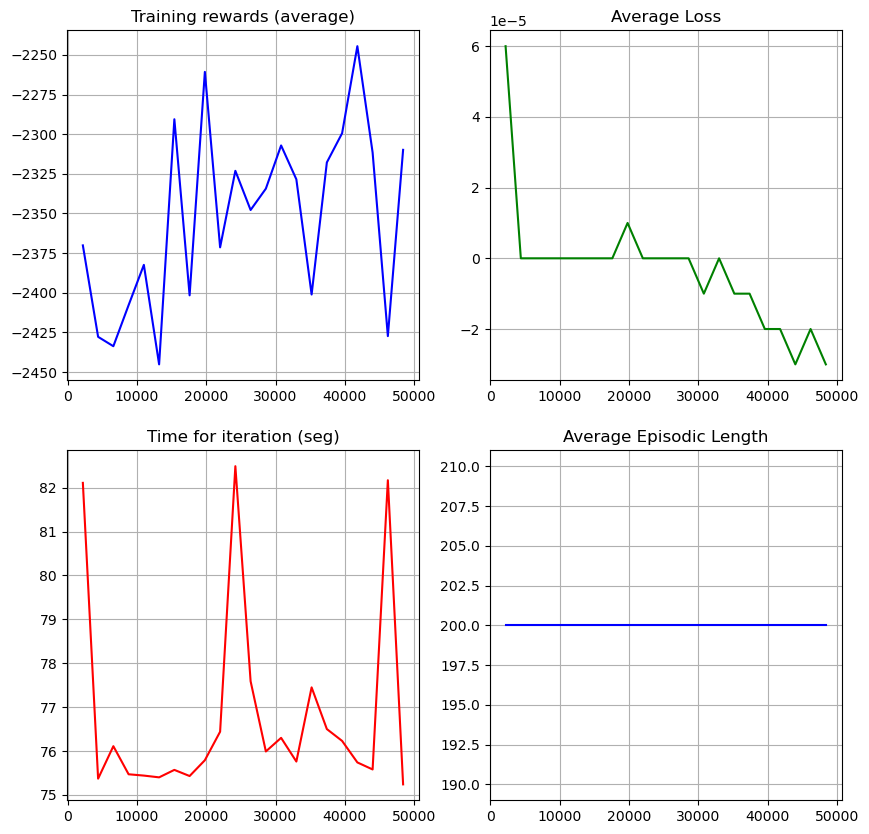

<Figure size 640x480 with 0 Axes>

In [5]:
def train(env, hyperparameters, target_angle, actor_model, critic_model):
	"""
		Trains the model.

		Parameters:
			env - the environment to train on
			hyperparameters - a dict of hyperparameters to use, defined in main
			actor_model - the actor model to load in if we want to continue training
			critic_model - the critic model to load in if we want to continue training

		Return:
			None
	"""	
	print(f"Training", flush=True)

	# Create a model for PPO.
	model = PPO(policy_class=FeedForwardNN, env=env, **hyperparameters)

	# Tries to load in an existing actor/critic model to continue training on
	if actor_model != '' and critic_model != '':
		print(f"Loading in {actor_model} and {critic_model}...", flush=True)
		model.actor.load_state_dict(torch.load(actor_model))
		model.critic.load_state_dict(torch.load(critic_model))
		print(f"Successfully loaded.", flush=True)
	elif actor_model != '' or critic_model != '': # Don't train from scratch if user accidentally forgets actor/critic model
		print(f"Error: Either specify both actor/critic models or none at all. We don't want to accidentally override anything!")
		sys.exit(0)
	else:
		print(f"Training from scratch.", flush=True)

	# Train the PPO model with a specified total timesteps
	# NOTE: You can change the total timesteps here, I put a big number just because
	# you can kill the process whenever you feel like PPO is converging
	#model.learn(total_timesteps=200_000_000)
	#model.learn(total_timesteps=1_000_000)
	model.learn(total_timesteps=100_000, target_angle=target_angle)

def test(env, target_angle, actor_model):
	"""
		Tests the model.

		Parameters:
			env - the environment to test the policy on
			actor_model - the actor model to load in

		Return:
			None
	"""
	print(f"Testing {actor_model}", flush=True)

	# If the actor model is not specified, then exit
	if actor_model == '':
		print(f"Didn't specify model file. Exiting.", flush=True)
		sys.exit(0)

	# Extract out dimensions of observation and action spaces
	obs_dim = env.observation_space.shape[0]
	act_dim = env.action_space.shape[0]

	# Build our policy the same way we build our actor model in PPO
	policy = FeedForwardNN(obs_dim, act_dim).to(device)

	# Load in the actor model saved by the PPO algorithm
	policy.load_state_dict(torch.load(actor_model))

	# Evaluate our policy with a separate module, eval_policy, to demonstrate
	# that once we are done training the model/policy with ppo.py, we no longer need
	# ppo.py since it only contains the training algorithm. The model/policy itself exists
	# independently as a binary file that can be loaded in with torch.
	eval_policy(policy=policy, env=env, render=True, target_angle=target_angle)

def main(args):
	"""
		The main function to run.

		Parameters:
			args - the arguments parsed from command line

		Return:
			None
	"""
	# NOTE: Here's where you can set hyperparameters for PPO. I don't include them as part of
	# ArgumentParser because it's too annoying to type them every time at command line. Instead, you can change them here.
	# To see a list of hyperparameters, look in ppo.py at function _init_hyperparameters
	hyperparameters = {
				'timesteps_per_batch': 2048, 
				'max_timesteps_per_episode': 200, 
				'gamma': 0.99, 
				'n_updates_per_iteration': 10,
				'lr': 3e-4, 
				'clip': 0.2,
				'render': True,
				'render_every_i': 10
			  }

	# Creates the environment we'll be running. If you want to replace with your own
	# custom environment, note that it must inherit Gym and have both continuous
	# observation and action spaces.
	env = gym.make('Pendulum-v1', render_mode="human", g=9.81)
	#env = gym.make('Pendulum-v1', render_mode="rgb_array", g=9.81)

	# Train or test, depending on the mode specified
	if args.mode == 'train':
		train(env=env, hyperparameters=hyperparameters, target_angle=int(args.target_angle), actor_model=args.actor_model, critic_model=args.critic_model)
	else:
		test(env=env, target_angle=int(args.target_angle), actor_model=args.actor_model)

if __name__ == '__main__':
	#args = get_args() # Parse arguments from command line # Just for .py files
	args = argparse.Namespace(mode='train', target_angle='135', actor_model='', critic_model='')
	#args = argparse.Namespace(mode='test', target_angle='0', actor_model='actor-critic/ppo_actor.pth', critic_model='actor-critic/ppo_critic.pth')
	main(args)

In [ ]:
print(torch.cuda.is_available())

In [ ]:
prueba = str("90")

print(int(prueba)*2)